## EDA and Data Preprocessing

According to the README.md from https://github.com/zalandoresearch/fashion-mnist, we can use this function from Tensorflow to load the dataset. And it's already split for us.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


It would be more convenient to have the image as a flat vector, i.e. a 784-dimension Numpy array.

In [3]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

Let's have a look at some image.

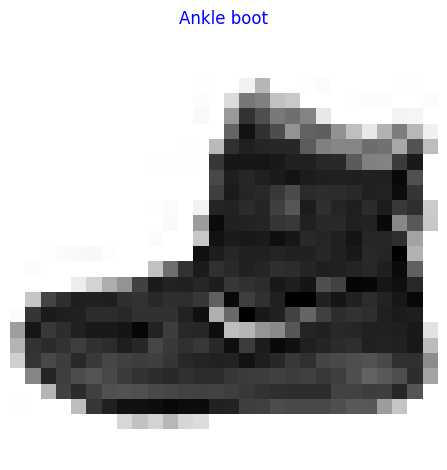

In [4]:
class_name = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

def plot_image(image_data: np.ndarray, label:int):
    image_data = image_data.reshape(28, 28)
    plt.imshow(image_data, cmap="binary")
    plt.title(class_name[label], color = "blue")
    plt.axis("off")
    plt.tight_layout()

plot_image(X_train[0], y_train[0])
plt.show()

An image doesn't tell very much though. Let's have a peek at the first 64 images from the train set.

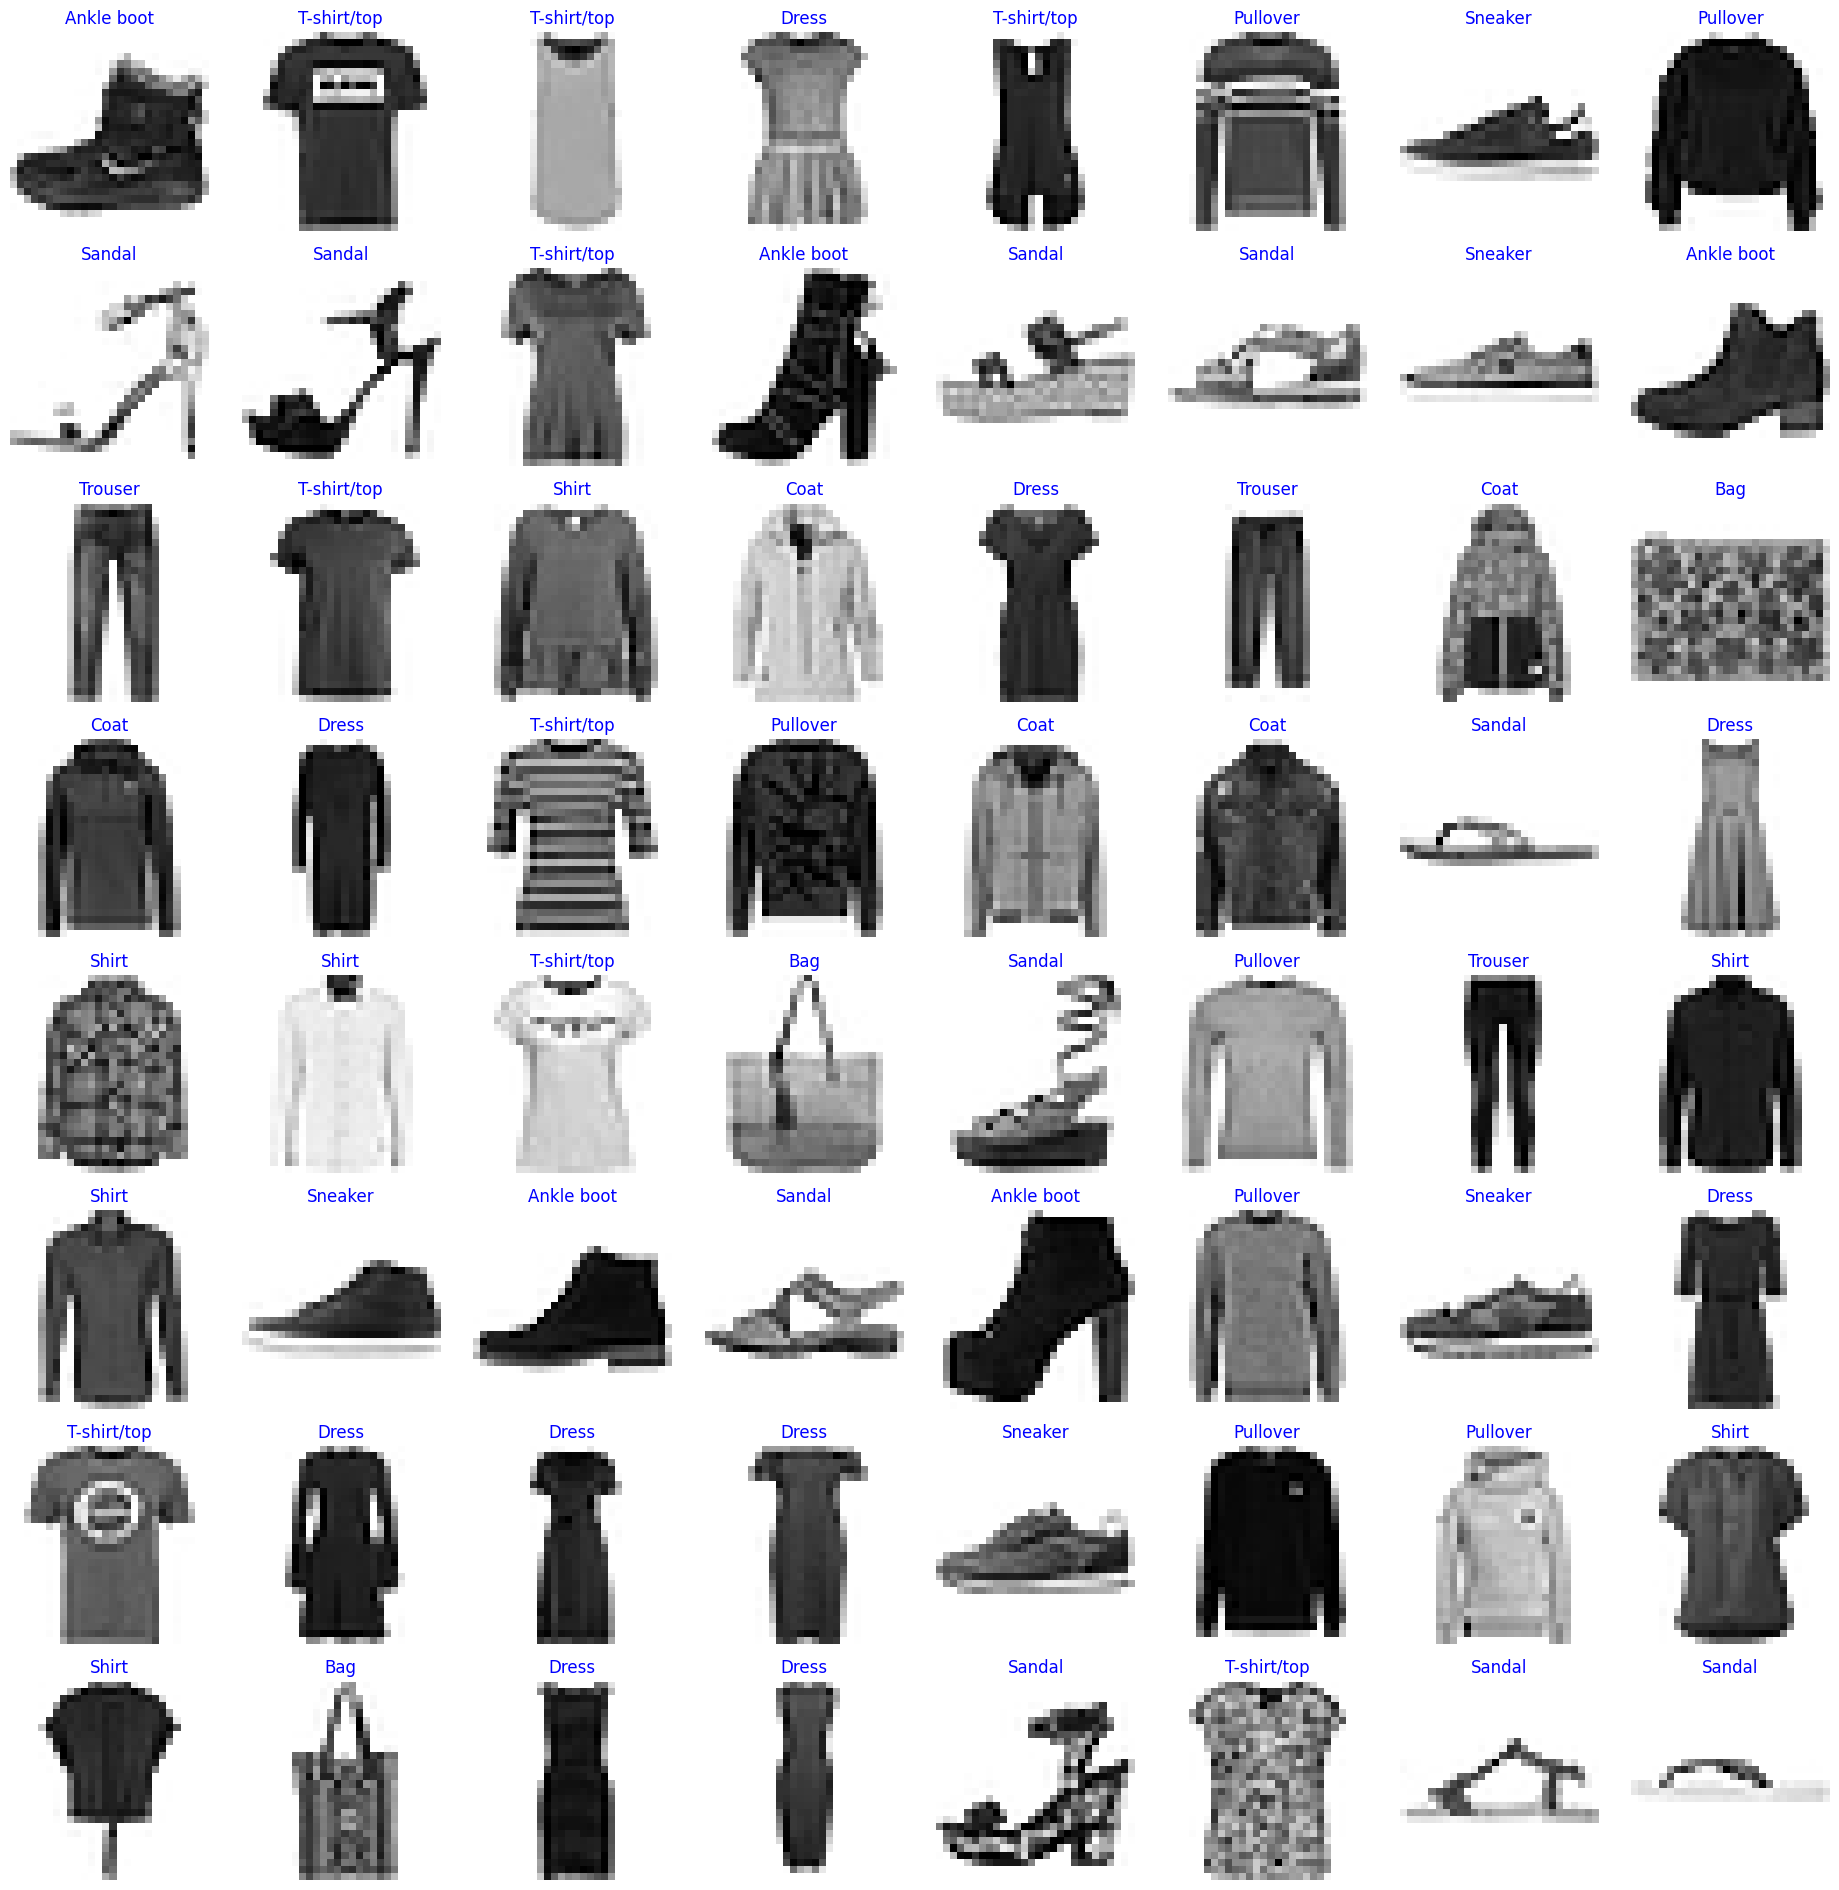

In [5]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(19, 19))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index], y_train[index])

plt.show()

From their documentation, the data is already cleaned for us, so no image preprocessing is required (I don't think I'm better than the expert at this).

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

There are ten classes, with the exact same amount across all of them in both train and test set.
Here are the class names and their corresponding indices:

| Index | Class Name    |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

In [7]:
# Optionally, here are the scaled version of the X sets, though I think you shouldn't use it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## Logistic Regression

### Train Linear Model - Logistic Regression

Training with native logistic regression first

In [9]:
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=10000)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

# do cross-validation with cuml LogisticRegression
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    log_reg.fit(X_train_fold, y_train_fold)
    
    y_pred = log_reg.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

print(f"Accuracy of cuML logistic regression: {np.mean(accuracies):.2f}")


Accuracy of cuML logistic regression: 0.84


### Tuning Logistic Regression Model

I use `GridSearchCV` to search the best.

Parameters will be fine tune are:
- `C`: regularization, because it helps prevent **overfiting**, if it too small, model will be overfit, otherwise model will be underfit.

In [6]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solvers = ['qn'] # 'qn' is equal to 'newton-cg' of scikit-learn
best_accuracy = 0
best_params = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for C in C_values:
    for solver in solvers:
        accuracies = []
        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # init model with hyper params
            model = LogisticRegression(C=C, solver=solver, max_iter=10000) # max_iter to make sure that model converged
            
            # train model
            model.fit(X_train_fold, y_train_fold)
            
            
            # predict on valid
            y_pred = model.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_pred)
            accuracies.append(accuracy)
        
        # calculate mean accuracy
        avg_accuracy = np.mean(accuracies)
        print(f"Parameters: C={C}, solver={solver} => Accuracy: {avg_accuracy:.2f}")
        
        # update params if these are better 
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'solver': solver}

print("\nBest parameters:", best_params)
print("Best accuracy:", best_accuracy)

Parameters: C=0.001, solver=qn => Accuracy: 0.85

Parameters: C=0.01, solver=qn => Accuracy: 0.86

Parameters: C=0.1, solver=qn => Accuracy: 0.85

Parameters: C=1, solver=qn => Accuracy: 0.84

Parameters: C=10, solver=qn => Accuracy: 0.83

Parameters: C=100, solver=qn => Accuracy: 0.83

Parameters: C=1000, solver=qn => Accuracy: 0.83



Best parameters: {'C': 0.01, 'solver': 'qn'}

Best accuracy: 0.8568166666666667


### Evaluate Logistic Regression Model

Train all training data, then evaluate on test set with metrics

Metrics:
- Accuracy
- Precision
- Recall
- F1 Score

In [18]:
import pickle
from cuml.linear_model import LogisticRegression
import time

start_time = time.time()
best_logistic_regression = LogisticRegression(C=0.01,solver='qn', max_iter=10000)
best_logistic_regression.fit(X_train_scaled, y_train) # the whole data set
training_time = time.time() - start_time

# Save the model to a file
with open("cuml_logistic_regression_model.pkl", "wb") as f:
    pickle.dump(best_logistic_regression, f)


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
start_time = time.time()
y_pred_log_reg = best_logistic_regression.predict(X_test_scaled)

acc_score = accuracy_score(y_test, y_pred_log_reg)
prec_score = precision_score(y_test, y_pred_log_reg, average='macro')
rec_score = recall_score(y_test, y_pred_log_reg, average='macro')
f1 = f1_score(y_test, y_pred_log_reg, average='macro')
cm = confusion_matrix(y_test, y_pred_log_reg)
evaluation_time = time.time() - start_time

print(f"Training time: {training_time}")
print(f"Evaluation time: {evaluation_time}")
print(f"Accuracy on test set: {acc_score:.6f}")
print(f"Precision score on test set: {prec_score:.6f}")
print(f"Recall score on test set: {rec_score:.6f}")
print(f"f1 score on test set: {f1:.6f}")

Training time: 53.040340423583984
Evaluation time: 0.052018165588378906
Accuracy on test set: 0.846700
Precision score on test set: 0.845527
Recall score on test set: 0.846700
f1 score on test set: 0.845797


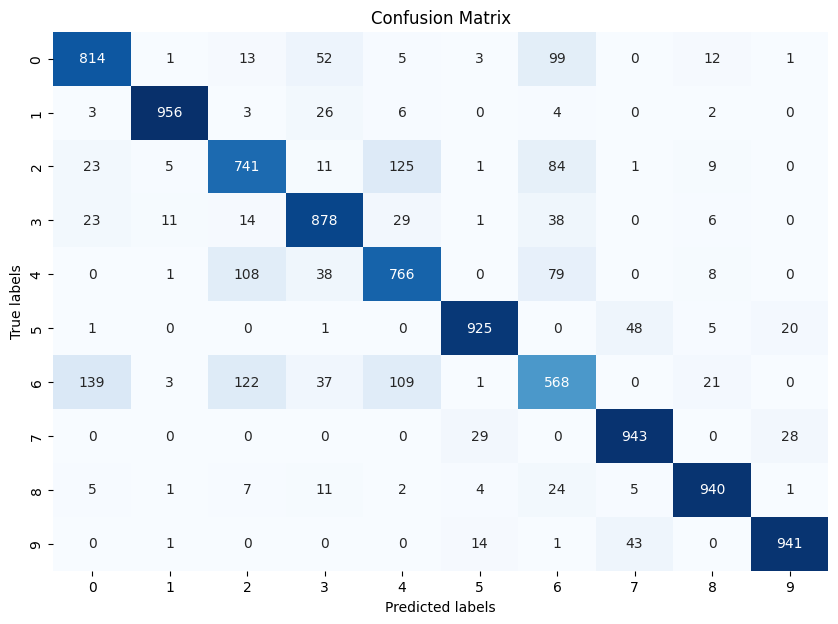

In [13]:
# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar = False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### Discuss about Logistic Regression with observed patterns

In [17]:
wrong_indexes = np.where(y_test != y_pred_log_reg)[0]
print(f"There are {len(wrong_indexes)} wrong predicted cases")

There are 1529 wrong predicted cases


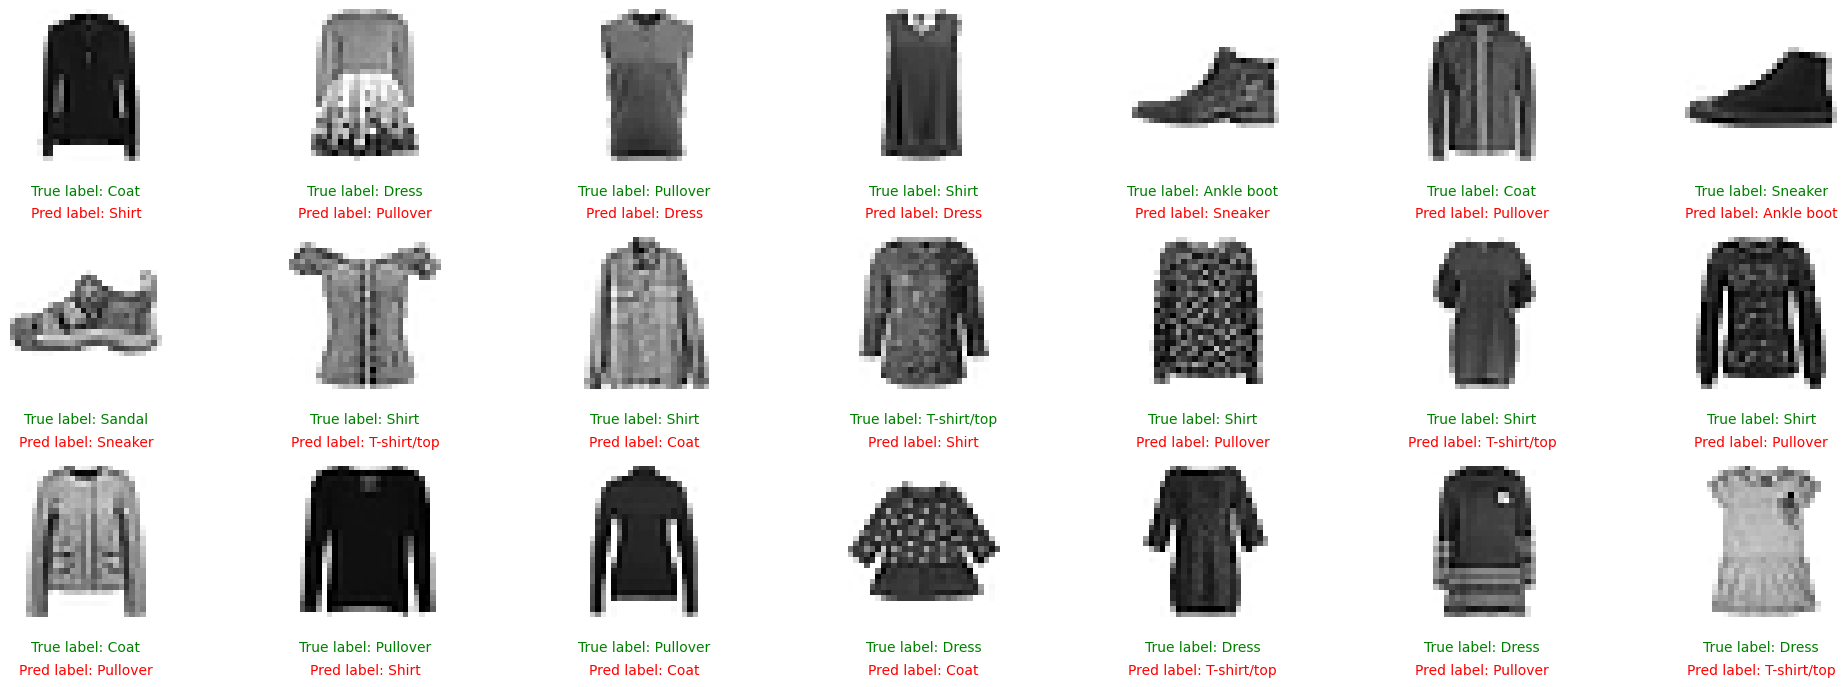

In [20]:
N = 21
random_indexes = np.random.choice(wrong_indexes, size=N, replace=False)
plt.figure(figsize=(20, 7))
n_cols = 7
n_rows = int(np.ceil(N/n_cols))


for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        if index < N:
            plt.subplot(n_rows, n_cols, index + 1)
            image_index = random_indexes[index]
            right_label = y_test[image_index]
            wrong_label = y_pred_log_reg[image_index]
            image_data = X_test[image_index].reshape(28, 28)
            plt.imshow(image_data, cmap="binary")
            plt.axis("off")

            plt.text(
                0.5, -0.15, f"True label: {class_name[right_label]}", color="green", ha="center", va="top", transform=plt.gca().transAxes
            )
            plt.text(
                0.5, -0.3, f"Pred label: {class_name[wrong_label]}", color="red", ha="center", va="top", transform=plt.gca().transAxes
            )

plt.tight_layout()
plt.show()

**1. Similar Shape and Silhouette:**
- The model often misclassifies items with similar shapes or silhouettes, such as "T-shirt/top" as "Shirt" and "Pullover" as "Shirt." These types of clothing items share a similar outline, which can be hard to distinguish in grayscale or low-resolution images, as the model may struggle to capture subtle differences in collar shape, sleeve length, or fabric texture.

**2. Confusion between Clothing Categories:**

- Instances of "Dress" are often predicted as "Coat" or "T-shirt/top." Dresses and coats can sometimes have similar lengths and shapes, particularly when rendered in grayscale, making it challenging for the model to differentiate between these items without additional color or texture information.

**3. Accessory and Clothing Misclassification:**

- There are examples where items like "Bag" and "Shirt" are confused, likely due to the presence of rectangular shapes in bags that can resemble certain shirt outlines in low-resolution images. This type of error suggests that the model may need to learn more specific features related to accessories versus apparel to avoid such confusion.
    
**4. Footwear Confusion:**

- The model occasionally mistakes "Sneaker" for "Sandal," possibly because both share similar shapes, especially in simplified images. This error suggests that the model might not be fully capturing unique footwear characteristics, like the open design of sandals versus the closed structure of sneakers.

<a href="https://www.kaggle.com/code/huvinh/svm-kfold-hypertuning?scriptVersionId=204100654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## SVM

In [15]:
import cuml
from cuml.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import gc
import torch 

### Finetuning

In this step, we will fine-tune the model on the training dataset using the K-Fold Cross Validation technique. However, because training on a large dataset can be time-intensive, we will use the `cuML` library by RapidsAI instead of the `SVC` model from `scikit-learn`.

The `cuML` library provides models with algorithms similar to `scikit-learn` but optimized for computation on the GPU rather than the CPU. This approach enables faster results.


In [10]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

param_grid = {'C': [0.1, 1, 10, 100]}
best_score = 0
best_params = {}

for C in param_grid['C']:
    fold_scores = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val = y_train[train_index], y_train[test_index]
        model = LinearSVC(C=C)
        model.fit(X_train, y_train_fold)

        y_pred = model.predict(X_val)
        score = accuracy_score(y_pred, y_val)
        fold_scores.append(score)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()

    avg_score = round(np.mean(fold_scores),6)
    print(f"Độ chính xác trung bình với C={C}: {avg_score}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1: 0.850167

Độ chính xác trung bình với C=1: 0.8491

Độ chính xác trung bình với C=10: 0.8485

Độ chính xác trung bình với C=100: 0.8486

Tham số tốt nhất: {'C': 0.1}

Độ chính xác cao nhất: 0.850167


In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
    'kernel': ['rbf']
}

best_score = 0
best_params = {}

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:

            fold_scores = []

            for train_index, test_index in kf.split(X_train_scaled):
                X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
                y_train_fold, y_val = y_train[train_index], y_train[test_index]

                model = SVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train_fold)

                y_pred = model.predict(X_val)
                score = accuracy_score(y_val, y_pred)
                fold_scores.append(score)
                
                del model
                gc.collect()
                torch.cuda.empty_cache()

            avg_score = round(np.mean(fold_scores),6)
            print(f"Độ chính xác trung bình với C={C}, gamma={gamma}, kernel={kernel}: {round(avg_score,6)}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}



print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1, gamma=1, kernel=rbf: 0.09755

Độ chính xác trung bình với C=0.1, gamma=0.1, kernel=rbf: 0.09755

Độ chính xác trung bình với C=0.1, gamma=0.01, kernel=rbf: 0.640167

Độ chính xác trung bình với C=0.1, gamma=0.001, kernel=rbf: 0.84755

Độ chính xác trung bình với C=0.1, gamma=0.0001, kernel=rbf: 0.793467

Độ chính xác trung bình với C=0.1, gamma=auto, kernel=rbf: 0.849817

Độ chính xác trung bình với C=1, gamma=1, kernel=rbf: 0.098283

Độ chính xác trung bình với C=1, gamma=0.1, kernel=rbf: 0.178817

Độ chính xác trung bình với C=1, gamma=0.01, kernel=rbf: 0.7991

Độ chính xác trung bình với C=1, gamma=0.001, kernel=rbf: 0.8881

Độ chính xác trung bình với C=1, gamma=0.0001, kernel=rbf: 0.851283

Độ chính xác trung bình với C=1, gamma=auto, kernel=rbf: 0.890633

Độ chính xác trung bình với C=10, gamma=1, kernel=rbf: 0.098333

Độ chính xác trung bình với C=10, gamma=0.1, kernel=rbf: 0.199517

Độ chính xác trung bình với C=10, gamma=0.01, kernel=rbf: 0.8

### Training and Evaluation 2 SVC models with best parameters

In the following step, I will create a custom class to store essential information for model evaluation. This class will include:

- Training time
- Evaluation time
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix


In [14]:
class Model:
    def __init__(self, name, model, X_train, y_train, X_test, y_test):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_time = None
        self.evaluate_time = None
        self.y_pred = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1_score = None
        self.confusion_matrix = None

    def train(self):
        start_time = time.time()
        self.model.fit(self.X_train, self.y_train)
        self.train_time = time.time() - start_time

    def evaluate(self):
        start_time = time.time()

        self.y_pred = self.model.predict(self.X_test)

        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.precision = precision_score(self.y_test, self.y_pred, average='weighted')
        self.recall = recall_score(self.y_test, self.y_pred, average='weighted')
        self.f1_score = f1_score(self.y_test, self.y_pred, average='weighted')
        self.confusion_matrix = confusion_matrix(self.y_test, self.y_pred)

        self.evaluate_time = time.time() - start_time

    def display_metrics(self):
        print(f"Model Name: {self.name}")
        print(f"Training Time: {self.train_time:.4f} seconds")
        print(f"Evaluation Time: {self.evaluate_time:.4f} seconds")
        print(f"Accuracy: {self.accuracy:.6f}")
        print(f"Precision: {self.precision:.6f}")
        print(f"Recall: {self.recall:.6f}")
        print(f"F1-score: {self.f1_score:.6f}")

        plt.figure(figsize=(8, 6))
        sns.heatmap(self.confusion_matrix, cmap="Reds", annot=True, fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

Model Name: Linear Kernel SVC
Training Time: 6.4390 seconds
Evaluation Time: 0.0417 seconds
Accuracy: 0.840500
Precision: 0.838054
Recall: 0.840500
F1-score: 0.838158


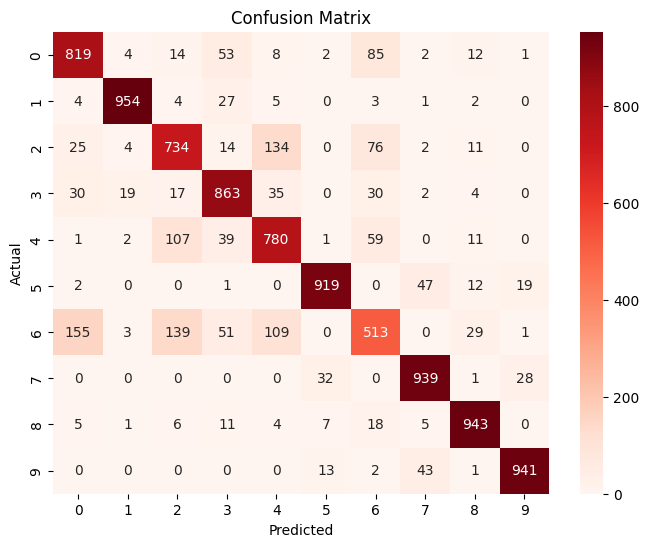

In [16]:
linear = Model(name="Linear Kernel SVC", model=LinearSVC(C=0.1), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
linear.train()
linear.evaluate()
linear.display_metrics()
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear.model, file)

Model Name: RBF_SVC
Training Time: 24.4439 seconds
Evaluation Time: 8.4204 seconds
Accuracy: 0.899500
Precision: 0.899252
Recall: 0.899500
F1-score: 0.899313


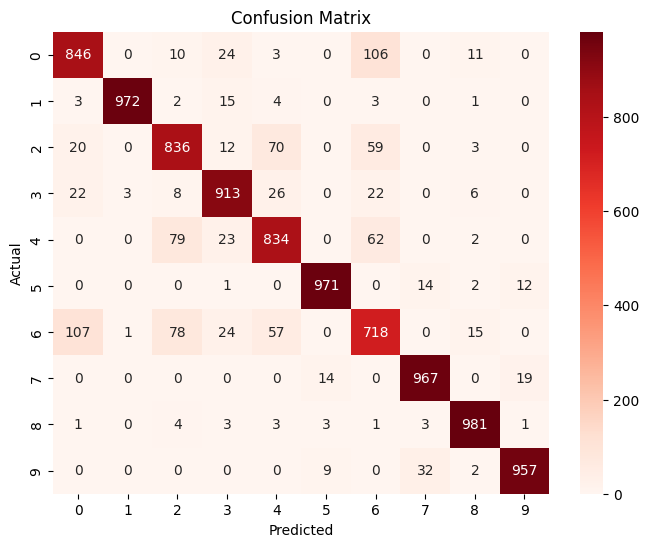

In [17]:
rbf = Model(name="RBF_SVC", model=SVC(C= 10, gamma= 'auto', kernel= 'rbf'), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
rbf.train()
rbf.evaluate()
rbf.display_metrics()
with open('rbf_model.pkl', 'wb') as file:
    pickle.dump(rbf.model, file)

### Comparison of Model Performance

| Model Name             | Accuracy | Precision | Recall | F1-score |
|------------------------|----------|-----------|--------|----------|
| **RBF SVC**            | 0.8995   | 0.8993    | 0.8995 | 0.8993   |
| **Linear Kernel SVC**  | 0.8405   | 0.8381    | 0.8405 | 0.8382   |
| **Logistic Regression**| 0.8467   | 0.8455    | 0.8467 | 0.8458   |


#### Model Performance Analysis

Based on the performance comparison of the three models, here are some observations:

1. **RBF SVC**:
   - **Highest Performance**: With all metrics (Accuracy, Precision, Recall, and F1-score) around 0.899, the RBF SVC model has the best overall performance among the three.
   - **Advantage**: This model is a solid choice if aiming to optimize accuracy and maintain consistency across all evaluation metrics.

2. **Logistic Regression**:
   - **Moderate Performance**: The Logistic Regression model achieves Accuracy, Precision, Recall, and F1-score around 0.846, which is lower than RBF SVC but higher than Linear Kernel SVC.
   - **Stability**: This model is also well-balanced across metrics, making it a feasible choice when simplicity and stability are preferred.

3. **Linear Kernel SVC**:
   - **Lowest Performance**: The Linear Kernel SVC model has the lowest scores across the board compared to the other two models, with an Accuracy of only 0.840.
   - **Limited Applicability**: This model may not be the optimal choice if high accuracy is a key requirement.

#### Summary:
- **RBF SVC** is the best model for this task if optimal performance is required.
- **Logistic Regression** is a suitable choice if you prefer a simpler model with relatively high and balanced performance.
- **Linear Kernel SVC** may need further adjustments or reconsideration if its performance isn't good.

### Comparison model's training time & evaluation time

| Model Name             | Training time | Evaluation time | 
|------------------------|---------------|-----------------|
| **RBF SVC**            |    53.0403     |     8.4204 | 
| **Linear Kernel SVC**  |    6.4390     |     0.0417      |
| **Logistic Regression**|    24.4439     |     0.0520      | 

We can observe that in terms of both Training time and Evaluation time across all three algorithms, **RBF SVC** takes the most time, followed by **Logistic Regression**, while **LinearSVC** leads in speed.

So, what is the reason behind this? Let’s delve deeper into how these algorithms operate.

#### 1. **RBF Kernel SVC**
   - **Mathematical Formula of the RBF Kernel**:
     $$
     K(x, x') = \exp \left(-\gamma ||x - x'||^2 \right)
     $$
     Here, $\gamma$ is a parameter that adjusts the influence of a data point. If $x$ and $x'$ are close, $K(x, x')$ will be near 1; conversely, if the distance is large, the kernel value will be close to 0.

   - **Reasons for High Computation Time**:
     - **Space Transformation**: The RBF Kernel transforms data from the input space to a multi-dimensional space where data points become more linearly separable. This increases complexity, as each data point must compute relationships with all other points using the above formula.
     - **Computational Complexity**: With the RBF kernel, the algorithm calculates every data point with the kernel formula, so the number of calculations increases quadratically with the number of points $(O(n^2))$, significantly increasing training time.
     - **Iteration Count for Optimization**: Since the model aims to optimize the boundary for accurate classification in a high-dimensional space, the iteration count for convergence also increases, extending training time.

#### 2. **Linear Kernel SVC**
   - **Mathematical Formula of the Linear Kernel**:
     $$K(x, x') = x \cdot x'$$
     Here, $x \cdot x'$ is the dot product between two data points. For the linear kernel, no space transformation is needed, allowing the model to train directly on the original data.

   - **Reasons for Fast Computation Time**:
     - **Linear Space**: Linear SVC performs well on linearly separable datasets and does not require space transformation, which significantly reduces computation time.
     - **Simpler Optimization**: Without the complex calculations of the RBF kernel, Linear SVC only needs to optimize a linear separation boundary, reducing the number of calculations substantially to $O(n)$, where $n$ is the number of data points.
     - **Direct Classification**: During evaluation, classification only requires calculating the dot product of the new point with the learned weight vector, making evaluation time extremely fast.

#### 3. **Logistic Regression**
   - **Mathematical Formula of Logistic Regression**:
     $$
     P(y=1|x) = \frac{1}{1 + e^{-(w \cdot x + b)}}
     $$
     Here, $w$ is the weight vector and $b$ is the intercept. Logistic Regression is a linear probability model that seeks to optimize weights to determine the probability of a point belonging to a specific class.

   - **Reasons for Fast Training and Evaluation Time**:
     - **Linear Space**: Like Linear SVC, Logistic Regression operates in linear space and does not require space transformation, reducing the number of computations.
     - **Loss Function**: Logistic Regression uses a logarithmic loss function, which is easily optimized using gradient descent or other optimization methods, with a complexity of $O(n)$, where $n$ is the number of data points.
     - **Fast Evaluation**: During evaluation, Logistic Regression only requires calculating the dot product of the weights and new data point, followed by applying the sigmoid function. This is simpler and faster compared to the RBF kernel.

#### Summary:
   - **RBF Kernel SVC** is complex due to space transformation and requires calculations for each data point in a non-linear space, leading to significantly higher training and evaluation times.
   - **Linear Kernel SVC** and **Logistic Regression** are simpler and faster as they operate in a linear space, with calculations mainly involving dot products and linear optimization, making them suitable for tasks requiring fast computation times.

In general, if the data can be linearly separated, Linear SVC or Logistic Regression would be optimal choices for speed. On the other hand, if the data is highly non-linear, RBF Kernel SVC may provide better accuracy at the cost of higher computation time.
